# import

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import statistics
import seaborn as sns

#functions
def load_in_paths(pp_file, PP_PATH, DAT_PATH):
    mir = '_'.join(pp_file.split('_')[0:3])
    print(str(run_index+1) + '/' + str(len(os.listdir(PP_PATH))-1) + '-------------------------------------------------------------------------')
    print(pp_file)
    mouse_session_recording = pp_file.split('_')[0] + '_' + pp_file.split('_')[1] + '_' + pp_file.split('_')[2] 
    skip = False
    for item in ignore_list:
        if item == mouse_session_recording:
            skip = True

    save_path = PP_PATH + pp_file + '\\_final_analysis_output\\'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    ## set dat_path:
    for file_ in os.listdir(DAT_PATH):
        if mouse_session_recording.split('_')[0] in file_:
            if mouse_session_recording.split('_')[1] == file_[-1]:
                dat_path = os.path.join(DAT_PATH,file_)
    for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
        if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
            dat_path = os.path.join(dat_path,recording)

    # set tracking path
    for file_ in os.listdir(dat_path + r"\video\tracking\\"):
        if 'task' in file_:
            if not 'clock' in file_:
                tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
   
    return mir,mouse_session_recording,save_path,tracking_path,dat_path

def load_PPSEQ_data(PP_PATH,pp_file,dat_path,mouse_session_recording):

    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
    ## LOAD 
    print("LOADING PPSEQ DATA")
    print('\n')
    #The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
    assignment_history_df = pd.read_csv(PP_PATH + pp_file + r"\assigment_hist_frame.csv")

    # latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
    latent_event_history_df = pd.read_csv(PP_PATH + pp_file + r"\latent_event_hist.csv")

    # seq_type_log_proportions: log p of each type of sequence at each iteration
    seq_type_log_proportions_df = pd.read_csv(PP_PATH + pp_file + r"\seq_type_log_proportions.csv")

    # neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
    # Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
    neuron_response_df = pd.read_csv(PP_PATH + pp_file + r"\neuron_response.csv")

    masking = False
    for dat_files in os.listdir(PP_PATH + pp_file):
        if 'unmasked_spikes' in dat_files:
            masking = True
            print('masking was used')

    if masking == True:
        #log_p_hist.csv: the history of the log_p of the model
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\test_log_p_hist.csv")

        unmasked_spikes_df = pd.read_csv(PP_PATH + pp_file + r"\unmasked_spikes.csv")
    else:
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\log_p_hist.csv")

        spikes_file = os.path.join(PP_PATH + pp_file,'trainingData\\') + mouse_session_recording + '.txt'
        neuron_ids, spike_times= [], []
        with open(spikes_file) as f:
            for (i, line) in enumerate(f.readlines()):
                neuron_id, spike_time = line.split('\t')
                spike_time = float(spike_time.strip())
                neuron_id = float(neuron_id)
                spike_times.append(spike_time)
                neuron_ids.append(neuron_id)
        unmasked_spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 
        bkgd_log_proportions_array = pd.read_csv(PP_PATH + pp_file + r"\bkgd_log_proportions_array.csv")

    # Opening JSON file
    f = open(PP_PATH + pp_file + r'\config_file.json')
    # returns JSON object as a dictionary
    config = eval(json.load(f))
    print(f'      done')

    ## LOAD behaviour data
    print('\n')
    print("LOADING BEHAV DATA")

    ## load in the timespan used for pppseq:
    input_params_path = os.path.join(PP_PATH + pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
    # Opening JSON file
    f = open(input_params_path)
    # returns JSON object as 
    # a dictionary
    input_config = json.load(f)
    behav_time_interval_start = input_config['time_span']
    print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")

    ### load in data:
    for sub_file in os.listdir(dat_path + '\\behav_sync\\'):
        if 'task' in sub_file:
            behav_sync_path = dat_path + '\\behav_sync\\' + sub_file +'\\'
    behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
    transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

    return assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start

def plot_save_log_l_curve(log_p_hist_df,save_path):
    # find 95% of growth value and when it crossed this
    max_ = max(log_p_hist_df.x1)
    min_ = min(log_p_hist_df.x1)
    growth = max_ - min_
    _prcntile =  max_ - (0.02 * growth)

    ## model log likley hood curve
    plt.plot(log_p_hist_df.x1)
    plt.axhline(y=_prcntile, color='r', linestyle='--')

    SaveFig('log_l_curve.pdf',save_path)

# Function to find corresponding number in another column
def find_corresponding(nums):
    return [df_dict[num] for num in nums]

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
#     plt.show()
    plt.close()

def plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, save_path):
    # calculate interval timings and end points
    interval_lengths = []
    for interval in behav_time_interval_start:
        interval_lengths += [np.diff(interval)[0]]
    total_time = sum(interval_lengths)
    interval_end_points = np.cumsum(interval_lengths)

    # Plot sequences - basic
    timeframe = [0, total_time]
    mask = (spikes_df.timestamp > timeframe[0]) * (spikes_df.timestamp < timeframe[-1])

    # Define neuron order
    neuron_permute_loc = np.zeros(len(neuron_index))
    for i in range(len(neuron_index)):
        neuron_permute_loc[i] = int(list(neuron_index).index(i))
    neuron_order = neuron_permute_loc[(spikes_df.neuron - 1).astype(int)]

    # Plotting
    fig, [ax, ax2] = plt.subplots(2, 1, figsize=(20, 20))

    # Plot background in grey
    background_keep_mask = (spikes_df[mask].sequence_type_adjusted < 0) | (spikes_df[mask].sequence_type_adjusted >= 7.0)
    ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],
               marker='o', s=40, linewidth=0, color='lightgrey', alpha=0.3)
    c_ = np.array(colors)[spikes_df[mask][background_keep_mask].sequence_type_adjusted.values.astype(int)]
    ax2.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],
                marker='o', s=40, linewidth=0, color=c_, alpha=0.3)
    ax2.set_title('extra sequences and background only')

    # Plot spikes without background
    background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0) * \
                             (spikes_df[mask].sequence_type_adjusted != 7.0) * \
                             (spikes_df[mask].sequence_type_adjusted != 8.0)
    c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],
               marker='o', s=40, linewidth=0, color=c_, alpha=1)
    ax.set_title('held sequences in color and extra sequences + background in grey')

    for end_p in interval_end_points:
        ax.axvline(x=end_p, color='k')

    # Save the figure
    plt.savefig(save_path)
    plt.close()
    return interval_end_points,neuron_order


def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def split_list(numbers):
    chunks = []
    indices = []
    current_chunk = []
    current_indices = []
    for i, num in enumerate(numbers):
        if num == 0:
            if current_chunk:
                chunks.append(current_chunk)
                indices.append(current_indices)
                current_chunk = []
                current_indices = []
        else:
            current_chunk.append(num)
            current_indices.append(i)
    if current_chunk:
        chunks.append(current_chunk)
        indices.append(current_indices)
    return chunks, indices

# Function to create directory if it doesn't exist
def create_directory(path):
    if not os.path.isdir(path):
        os.mkdir(path)

# Function to save figure
def save_figure(fig, filename, path):
    fig.savefig(os.path.join(path, filename))


# Function to filter and save replay clusters
def filter_and_save_replay_clusters(neuron_order,iteration, chunk_df, chunk_path, r_seq_type, r_start_, r_end_, colors, min_spikes_filter, min_neurons_involved_filter):
    filtered_data = {
        'cluster_seq_type': [],
        'num_spikes': [],
        'num_neurons': [],
        'first_spike_time': [],
        'event_length': [],
        'last_spike_time': [],
        'cluster_spike_times': [],
        'cluster_neurons': [],
        'spike_plotting_order': []
    }

    for i in range(len(r_seq_type)):
        r_event_df = chunk_df[(chunk_df.timestamp >= r_start_[i]) & (chunk_df.timestamp <= r_end_[i])].copy()
        neuron_orders = neuron_order[(chunk_df.timestamp >= r_start_[i]) & (chunk_df.timestamp <= r_end_[i])]
        neuron_orders = neuron_orders[r_event_df.sequence_type_adjusted == r_seq_type[i]]
        r_event_df = r_event_df[r_event_df.sequence_type_adjusted == r_seq_type[i]]

        if len(r_event_df) > 0:
            num_spikes = len(r_event_df.sequence_type_adjusted)
            num_neurons = len(r_event_df.neuron.unique())
            first_spike = min(r_event_df.timestamp)
            last_spike = max(r_event_df.timestamp)

            if num_spikes >= min_spikes_filter and num_neurons >= min_neurons_involved_filter:
                ax1.axvspan(first_spike, last_spike, color=colors[r_seq_type[i]], alpha=0.5)
                filtered_data['cluster_seq_type'].append(r_seq_type[i])
                filtered_data['num_spikes'].append(num_spikes)
                filtered_data['num_neurons'].append(num_neurons)
                filtered_data['first_spike_time'].append(first_spike)
                filtered_data['event_length'].append(last_spike - first_spike)
                filtered_data['last_spike_time'].append(last_spike)
                filtered_data['cluster_spike_times'].append(list(r_event_df.timestamp.values))
                filtered_data['cluster_neurons'].append(list(r_event_df.neuron.values))
                filtered_data['spike_plotting_order'].append(neuron_orders)

    filtered_r_clusters_df = pd.DataFrame(filtered_data)
    filtered_r_clusters_df.to_csv(os.path.join(chunk_path, 'filtered_replay_clusters_df_' + str(iteration)), index=False)
    
def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type


AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

# notes

this first analysis is done on awake runs (ie. out of the box PPSEQ)

1. simple plot showing loss over time - show that it stabilised
2. plot showing that for a single instance, the number of events is resonably stable across itterations 
3. plot showing that across indipendent runs the same number of events are found. (this one should probably be using the usual method - integrating all the spikes across the last couple of hundred itterations)

4. something extra, not something they asked for - I could show that in replay mode, using synthetic data perhaps, it finds the same number of events and even that spike labelleling is consistent across indipendent runs? 


do I need to run this on synthetic data??

also for the second plot I may need to compare across different animals.. and show normalised number found or something like that?




# preprocess data for across iterations

In [ ]:
ignore_list= []

# PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\output\\"
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\SynthSleep_output\\"

DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"


# PP_PATH = r"D:\\"

######################################################################################################################################################################################################################
# load in data, extract, filter PPseq spikes etc.
# main filtering here:
# backgroudn confidence - spike had to be classified as a seq type 75% of the time across the last 50 iterations to be kept.   
######################################################################################################################################################################################################################

for run_index,pp_file in enumerate(os.listdir(PP_PATH)[0:3]):
    
    if run_index >-1 and 'run' in pp_file:
        # load in paths for that specific mouse and recording
        mir,mouse_session_recording,save_path,tracking_path,dat_path = load_in_paths(pp_file, PP_PATH, DAT_PATH)
        
        ## load in PPseq output data
        assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start = load_PPSEQ_data(PP_PATH,pp_file,dat_path,mouse_session_recording)
        # plot out log l curve 
        plot_save_log_l_curve(log_p_hist_df,save_path)
        
    ## load in colors and order from awake data -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
    awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
    for file_ in os.listdir(awake_PP_path):
        if mouse_session_recording in file_:
            awake_file = file_
    ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')
    neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')
    colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')
    colors += ['pink','lightblue', 'k'] 

    # ---pull out spikes across itterations---------------------------------------------------------------------------------------------------------------------------------------------------------------    
    # Initialize an empty df to store the result
    seq_types_df = pd.DataFrame()
    # Iterate through the range
    for iteration_ in tqdm(range(249, 300)):
        # Extract the relevant column from the assignment history dataframe
        assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]
        # Get the index of the -1 split markers in the latent event history dataframe
        end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
        # Extract the relevant portion of the latent event history dataframe
        latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]
        # Create a dictionary from the dataframe for faster lookups
        df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()
        # Match the sequence ID to the sequence type
        seq_type = find_corresponding(assignment_history_df_split)
        # Append the result to the df
        seq_types_df[str(iteration_+1)] = seq_type
    proportion = []
    seq_type = []
    for index in tqdm(range(len(seq_types_df))):
        row = seq_types_df.loc[index]
        seq_type += [statistics.mode(row)] 
        proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]
        
    # Constants
    min_spikes_filter = 5
    min_neurons_involved_filter = 3
    bin_size = 0.02

    # save the labelled spikes out for each itteration
    for iteration in tqdm(range(250, 301)):
        spikes_path = save_path + '\data_across_iterations\\'
        create_directory(spikes_path)
        spikes_path= spikes_path + str(iteration) + '\\'
        if not (os.path.isdir(spikes_path)):
            create_directory(spikes_path)
            spikes_df['sequence_type_adjusted'] = seq_types_df[str(iteration)]
            spikes_df.to_csv(spikes_path + "unmaskedspikes_df_" + str(iteration) + ".csv", index=False)

            ############### plot simple rasters ------------------------------
            interval_end_points,neuron_order = plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, spikes_path + 'all_data_raster' + str(iteration) + '.png')

            # Main processing loop
            interval_start = 0
            index_ = 0
            # chunk_path = os.path.join(save_path, f'chunk{index_+1}_{behav_time_interval_start[index_][0]}to{behav_time_interval_start[index_][1]}\\')
            # # chunk_path = r"D:\MCMC"
            # chunk_paths.append(chunk_path)
            # create_directory(chunk_path)

            # np.save(os.path.join(chunk_path, 'chunk_time_interval.npy'), np.array(behav_time_interval_start[index_]))

            timeframe = [interval_start, interval_end_points[index_] - 1]
            total_time = np.diff(timeframe)[0] + 1
            mask = (spikes_df.timestamp > timeframe[0]) & (spikes_df.timestamp < timeframe[-1])

            fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(35, 15))

            background_remove_mask = (spikes_df[mask].sequence_type_adjusted > -1) & (spikes_df[mask].sequence_type_adjusted < 7)
            c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
            ax1.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask], marker='o', s=40, linewidth=0, color=c_, alpha=1)

            # chunk_mask = (spikes_df.timestamp > interval_start) & (spikes_df.timestamp < interval_end_points[index_])
            # chunk_df = spikes_df[chunk_mask].copy().reset_index(drop=True)
            # chunk_df.to_csv(os.path.join(chunk_path, 'unfiltered_spikes_data.csv'), index=False)

            # seqs = np.unique(chunk_df.sequence_type_adjusted)
            # seq_spikes = [chunk_df.timestamp[chunk_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]
            # seq_neurons = [chunk_df.neuron[chunk_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]

            seqs = np.unique(spikes_df.sequence_type_adjusted)
            seq_spikes = [spikes_df.timestamp[spikes_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]
            seq_neurons = [spikes_df.neuron[spikes_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]

            binned_seq_r_events = [np.histogram(spikes_, bins=np.arange(interval_start, interval_end_points[index_], bin_size))[0] for spikes_ in seq_spikes]

            strt_ = int(timeframe[0] / bin_size)
            end_ = int(timeframe[1] / bin_size)

            r_start_, r_end_, r_seq_type = [], [], []
            for _index_, sequence_type in enumerate(seqs):
                sequence_type = int(sequence_type)
                if 0 < sequence_type <= 6:
                    smoothed_binned_spikes = convolve_movmean(binned_seq_r_events[_index_], 2)
                    time_bins = np.arange(timeframe[0], timeframe[0] + np.diff(timeframe) + 1, bin_size)
                    ax2.plot(time_bins[:-1], smoothed_binned_spikes, c=colors[sequence_type])
                    ax2.sharex(ax1)

                    replay_chunks, indices = split_list(list(smoothed_binned_spikes))
                    for index, chunk in enumerate(replay_chunks):
                        r_seq_type.append(sequence_type)
                        r_start_.append(time_bins[indices[index][0]])
                        r_end_.append(time_bins[indices[index][-1]])

            ax1.set_xlim(timeframe[0] + 140, timeframe[0] + 150)
            ax2.set_xlim(timeframe[0] + 140, timeframe[0] + 150)

            save_figure(fig, f'zoomed_data_filtering_{iteration+1}.png', spikes_path)
            plt.close()

            filtered_r_clusters_df = filter_and_save_replay_clusters(neuron_order,iteration,spikes_df, spikes_path, r_seq_type, r_start_, r_end_, colors, min_spikes_filter, min_neurons_involved_filter)





1/8-------------------------------------------------------------------------
178_1_7_run_0111024_1930
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[5400, 6000]]


100%|███████████████████████████████████████████████████████████████████████████████████████| 51/51 [22:11<00:00, 26.11s/it]


2/8-------------------------------------------------------------------------
178_1_7_run_0111024_2004
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[5400, 6000]]


100%|███████████████████████████████████████████████████████████████████████████████████████| 51/51 [17:25<00:00, 20.50s/it]


3/8-------------------------------------------------------------------------
178_1_7_run_0111024_2009
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[5400, 6000]]


100%|███████████████████████████████████████████████████████████████████████████████████████| 51/51 [18:54<00:00, 22.24s/it]


# preprocess for final number of seqs

In [ ]:
ignore_list= []

# PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\output\\"
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\SynthSleep_output\\"
DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"

for run_index,pp_file in enumerate(os.listdir(PP_PATH)):
    
    if run_index >-1 and 'run' in pp_file:
        # load in paths for that specific mouse and recording
        mir,mouse_session_recording,save_path,tracking_path,dat_path = load_in_paths(pp_file, PP_PATH, DAT_PATH)
        
        ## load in PPseq output data
        assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start = load_PPSEQ_data(PP_PATH,pp_file,dat_path,mouse_session_recording)

        
    ## load in colors and order from awake data -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
    awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
    for file_ in os.listdir(awake_PP_path):
        if mouse_session_recording in file_:
            awake_file = file_
    ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')
    neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')
    colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')
    colors += ['pink','lightblue', 'k']
    
    # Initialize an empty df to store the result
    seq_types_df = pd.DataFrame()

    # Iterate through the range
    # for iteration_ in tqdm(range(400, 500)):
    for iteration_ in tqdm(range(199, 300)):

        # Extract the relevant column from the assignment history dataframe
        assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]

        # Get the index of the -1 split markers in the latent event history dataframe
        end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
        # Extract the relevant portion of the latent event history dataframe
        latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]

        # Create a dictionary from the dataframe for faster lookups
        df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()

        # Match the sequence ID to the sequence type
        seq_type = find_corresponding(assignment_history_df_split)

        # Append the result to the df
        seq_types_df[str(iteration_+1)] = seq_type


    proportion = []
    seq_type = []
    for index in tqdm(range(len(seq_types_df))):
        row = seq_types_df.loc[index]
        seq_type += [statistics.mode(row)] 
        proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]

    # add seq type to dataframe
    spikes_df['sequence_type'] = seq_type
    # add seq type to dataframe
    spikes_df['seq_confidence'] = proportion

    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    

    ## filter for background confidence :

    thresh = max(proportion) *.75
    plt.plot(np.sort(proportion)[::-1])
    plt.axhline(y = thresh, color = 'r', linestyle = '-')

    spikes_df['sequence_type_adjusted'] = seq_type
    spikes_df.sequence_type_adjusted[np.where(spikes_df.seq_confidence < thresh)[0]] = -1

    SaveFig('filtering_curve.png',save_path)

    # Opening JSON file
    f = open(PP_PATH + pp_file + r'\config_file.json')
    # returns JSON object as a dictionary
    config = eval(json.load(f))
    print(f'      done')

    #define neuron order
#     neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=[0,2,1,4,5,3])
#     # make a list of idndies for each neurons new position
#     neuron_permute_loc = np.zeros(len(neuron_index))
#     for i in range(len(neuron_index)):
#         neuron_permute_loc[i] = int(list(neuron_index).index(i))
#     neuron_order = neuron_permute_loc[spikes_df.neuron.values.astype(int)-1]


    ## save out data:
    spikes_df.to_pickle(save_path +  "spikes_seq_type_adjusted.pickle")
#     np.save(save_path+ 'neuron_order.npy', neuron_order)
#     np.save(save_path+ 'neuron_permute_loc.npy', neuron_permute_loc)
#     np.save(save_path+ 'ordered_preferred_type.npy', ordered_preferred_type)
#     np.save(save_path+ 'neuron_index.npy', neuron_index)
    latent_event_history_df_split.to_pickle(save_path +  "latent_event_history_df_split.pickle")
    
    
 # Constants
    min_spikes_filter = 5
    min_neurons_involved_filter = 3
    bin_size = 0.02

    filtered_spikes_df = pd.DataFrame()
    filtered_spikes_df['neuron'] = spikes_df['neuron']
    filtered_spikes_df['timestamp'] = spikes_df['timestamp']
    filtered_spikes_df['sequence_type'] = spikes_df['sequence_type_adjusted']
    filtered_spikes_df['sequence_type_adjusted'] = spikes_df['sequence_type_adjusted']
    
    ############### plot simple rasters ------------------------------
    interval_end_points,neuron_order = plot_data_raster(behav_time_interval_start, filtered_spikes_df, neuron_index, colors, save_path + 'all_data_raster.png')

    # Main processing loop
    interval_start = 0
    index_ = 0

    timeframe = [interval_start, interval_end_points[index_] - 1]
    total_time = np.diff(timeframe)[0] + 1
    mask = (filtered_spikes_df.timestamp > timeframe[0]) & (filtered_spikes_df.timestamp < timeframe[-1])

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(35, 15))

    background_remove_mask = (filtered_spikes_df[mask].sequence_type_adjusted > -1) & (filtered_spikes_df[mask].sequence_type_adjusted < 7)
    c_ = np.array(colors)[filtered_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax1.scatter(filtered_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask], marker='o', s=40, linewidth=0, color=c_, alpha=1)

    
    seqs = np.unique(filtered_spikes_df.sequence_type_adjusted)
    seq_spikes = [filtered_spikes_df.timestamp[filtered_spikes_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]
    seq_neurons = [filtered_spikes_df.neuron[filtered_spikes_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]

    binned_seq_r_events = [np.histogram(spikes_, bins=np.arange(interval_start, interval_end_points[index_], bin_size))[0] for spikes_ in seq_spikes]

    strt_ = int(timeframe[0] / bin_size)
    end_ = int(timeframe[1] / bin_size)

    r_start_, r_end_, r_seq_type = [], [], []
    for _index_, sequence_type in enumerate(seqs):
        sequence_type = int(sequence_type)
        if 0 < sequence_type <= 6:
            smoothed_binned_spikes = convolve_movmean(binned_seq_r_events[_index_], 2)
            time_bins = np.arange(timeframe[0], timeframe[0] + np.diff(timeframe) + 1, bin_size)
            ax2.plot(time_bins[:-1], smoothed_binned_spikes, c=colors[sequence_type])
            ax2.sharex(ax1)

            replay_chunks, indices = split_list(list(smoothed_binned_spikes))
            for index, chunk in enumerate(replay_chunks):
                r_seq_type.append(sequence_type)
                r_start_.append(time_bins[indices[index][0]])
                r_end_.append(time_bins[indices[index][-1]])
                
    ax1.set_xlim(timeframe[0] + 140, timeframe[0] + 150)
    ax2.set_xlim(timeframe[0] + 140, timeframe[0] + 150)

    save_figure(fig, f'zoomed_data_filtering_.png', save_path)
    plt.close()

    filtered_r_clusters_df = filter_and_save_replay_clusters(neuron_order,0,filtered_spikes_df, save_path, r_seq_type, r_start_, r_end_, colors, min_spikes_filter, min_neurons_involved_filter)


    
    



1/8-------------------------------------------------------------------------
178_1_7_run_0111024_1930
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[5400, 6000]]


 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 99/101 [00:08<00:00, 13.09it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_5208\3939183894.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  seq_types_df[str(iteration_+1)] = seq_type
100%|█████████████████████████████████████████████████████████████████████████████| 159426/159426 [00:49<00:00, 3208.69it/s]


      done
2/8-------------------------------------------------------------------------
178_1_7_run_0111024_2004
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[5400, 6000]]


 99%|████████████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:08<00:00, 12.81it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_5208\3939183894.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  seq_types_df[str(iteration_+1)] = seq_type
100%|█████████████████████████████████████████████████████████████████████████████| 159426/159426 [00:48<00:00, 3318.90it/s]


      done
3/8-------------------------------------------------------------------------
178_1_7_run_0111024_2009
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[5400, 6000]]


 99%|████████████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:08<00:00, 12.41it/s]C:\Users\Emmett\AppData\Local\Temp\ipykernel_5208\3939183894.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  seq_types_df[str(iteration_+1)] = seq_type
 61%|███████████████████████████████████████████████▍                              | 96922/159426 [00:30<00:19, 3199.15it/s]


KeyboardInterrupt: 

# preprocess for number of seqs across iterations

In [ ]:
# if not os.path.isfile(r'Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_total_seqs.npy'):

# load in the data 
# PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\output\\"
PP_PATH =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\SynthSleep_output\\"
AA_total_seqs = []
for i,mouse in enumerate(os.listdir(PP_PATH)):
    total_seqs  = []
    mouse_path = os.path.join(PP_PATH,mouse) 
    iteration_paths = os.listdir(os.path.join(mouse_path,'_final_analysis_output\\data_across_iterations\\'))

    for i in tqdm(range(len(iteration_paths))):
        iteration_path = os.path.join(mouse_path,'_final_analysis_output\\data_across_iterations\\',iteration_paths[i])
        for file_ in os.listdir(iteration_path):
            if 'filtered_replay_clusters_df' in file_:
                filtered_r_clusters_df = pd.read_csv(os.path.join(iteration_path,file_))
                total_seqs += [len(filtered_r_clusters_df)]
    AA_total_seqs += [total_seqs]
    print(mouse)
    print(np.mean(total_seqs))


# np.save(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_total_seqs.npy",AA_total_seqs)
np.save(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_total_seqs_syth_data.npy",AA_total_seqs)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 22.98it/s]


178_1_7_run_0111024_1930
621.843137254902


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 27.75it/s]


178_1_7_run_0111024_2009
616.0392156862745


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 25.76it/s]


178_1_7_run_0111024_2016
619.7254901960785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 23.25it/s]


178_1_7_run_0111024_2019
615.2745098039215


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 25.89it/s]


178_1_7_run_0111024_2041
556.156862745098


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 28.39it/s]


178_1_7_run_0111024_2223
624.0784313725491


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 26.11it/s]


178_1_7_run_0111024_2257
609.8627450980392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 26.74it/s]

178_1_7_run_0111024_2314
627.1372549019608


# preprocess for number of final filtered seqs



In [ ]:

# Path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\output\\"
Path =  r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\SynthSleep_output\\"

AA_filtered_total_seqs = []   
for i, model in enumerate(os.listdir(Path)):
    if not i in [1,2,5]:
        dat_path = os.path.join(Path,model) + '\\_final_analysis_output\\filtered_replay_clusters_df_0'
        dat_path = pd.read_csv(dat_path)
        AA_filtered_total_seqs+= [len(dat_path)]
        print(model)
        print(len(dat_path))
# AA_filtered_total_seqs.pop(3)

# np.save(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_filtered_total_seqs.npy",AA_filtered_total_seqs)
np.save(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_filtered_total__synthetic_seqs.npy",AA_filtered_total_seqs)

178_1_7_run_0111024_1930
352
178_1_7_run_0111024_2019
362
178_1_7_run_0111024_2041
340
178_1_7_run_0111024_2257
352
178_1_7_run_0111024_2314
352


# plot Awake data test

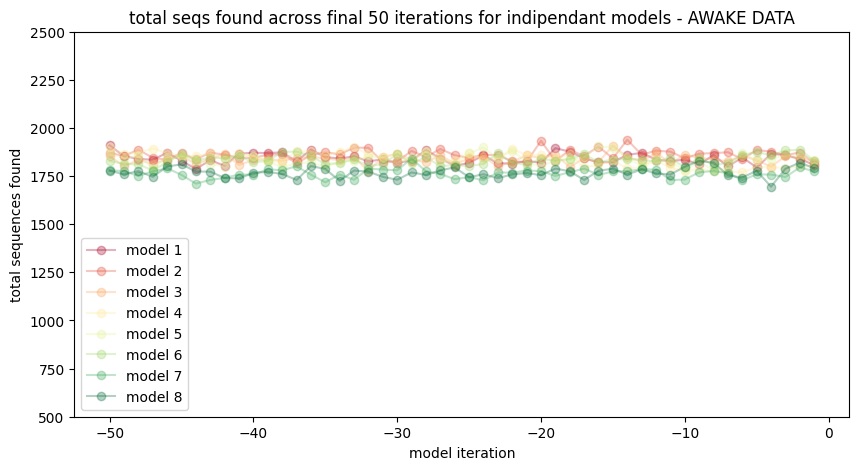

In [ ]:
## plot awake data

AA_total_seqs  = np.load(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_total_seqs.npy", allow_pickle = True)



fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(AA_total_seqs)))
for i, totals in enumerate(AA_total_seqs):
    if len(totals) > 50:
        totals = totals[1::]
    label = 'model ' + str(i+1)
    ax.plot(range(-50, 0), totals, '-o', c=colors[i], alpha=0.3, label=label)
ax.set_ylim(500, 2500)
ax.set_xlabel('model iteration')
ax.set_ylabel('total sequences found')
ax.set_title('total seqs found across final 50 iterations for indipendant models - AWAKE DATA')
ax.legend()

(1600.0, 2200.0)

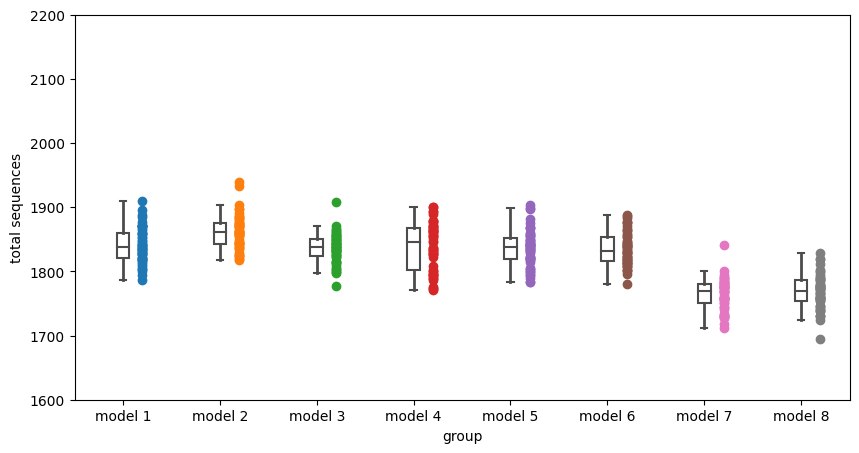

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
flattened_totals = [item for sublist in AA_total_seqs for item in sublist]
group_labels = [f'model {i+1}' for i in range(len(AA_total_seqs)) for _ in range(len(AA_total_seqs[i]))]
totals_df = pd.DataFrame({'group': group_labels, 'total sequences': flattened_totals})

for i,item in enumerate(AA_total_seqs):
    ax.plot([i+0.2]*len(item),item,'o')

ax = sns.boxplot(y='total sequences', x='group', data=totals_df, color='blue', width=.13, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')
ax.set_ylim(1600, 2200)

In [ ]:
import scipy
from scipy.stats import f_oneway
from scipy.stats import tukey_hsd


 
for item in AA_total_seqs:
    print(scipy.stats.shapiro(item))


# Conduct the one-way ANOVA
f_oneway(AA_total_seqs[0],AA_total_seqs[1],AA_total_seqs[2],AA_total_seqs[3],AA_total_seqs[4],AA_total_seqs[5])

results = tukey_hsd(AA_total_seqs[0],AA_total_seqs[1],AA_total_seqs[2],AA_total_seqs[3],AA_total_seqs[4],AA_total_seqs[5])

print(results)

ShapiroResult(statistic=0.986306886859729, pvalue=0.8260188322616488)
ShapiroResult(statistic=0.9614699132143076, pvalue=0.09636225964991399)
ShapiroResult(statistic=0.9746385959933562, pvalue=0.34103838224971617)
ShapiroResult(statistic=0.9478758606044747, pvalue=0.025721195887355098)
ShapiroResult(statistic=0.9771541132077152, pvalue=0.42598645295126264)
ShapiroResult(statistic=0.9741365938475678, pvalue=0.3258216515776488)
ShapiroResult(statistic=0.9593400744828586, pvalue=0.07817737372530535)
ShapiroResult(statistic=0.9891258939243266, pvalue=0.9190159946928128)
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    -20.306     0.005   -36.779    -3.833
 (0 - 2)      5.067     0.971   -11.406    21.540
 (0 - 3)      2.518     0.999   -13.955    18.991
 (0 - 4)      5.027     0.972   -11.446    21.501
 (0 - 5)      5.929     0.937   -10.544    22.402
 (0 - 6)     76.969     0.000    60.496    93.442
 (1 - 0) 

(500.0, 2500.0)

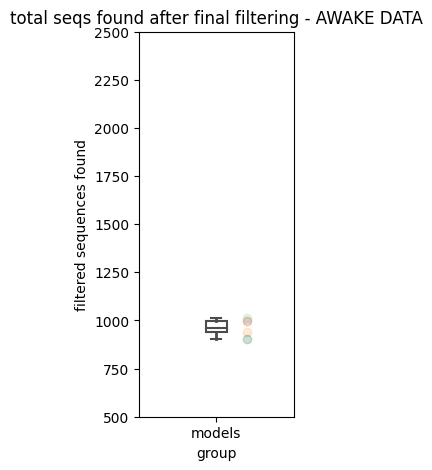

In [ ]:
AA_filtered_total_seqs = np.load(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_filtered_total_seqs.npy")

colors = plt.cm.RdYlGn(np.linspace(0, 1, len(AA_filtered_total_seqs)))

fig, ax = plt.subplots(1, 1, figsize=(2, 5))

for i,item in enumerate(AA_filtered_total_seqs):
    ax.plot(0.2, item,'o', alpha = 0.2,c=colors[i])


plt_df = pd.DataFrame({'group': ['models'] * len(AA_filtered_total_seqs), 'filtered sequences found': AA_filtered_total_seqs})
ax = sns.boxplot(y='filtered sequences found', x='group', data=plt_df, color='blue', width=.13, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

ax.set_title('total seqs found after final filtering - AWAKE DATA')

ax.set_ylim(500, 2500)

# plot SYNTHETIC REPLAY data

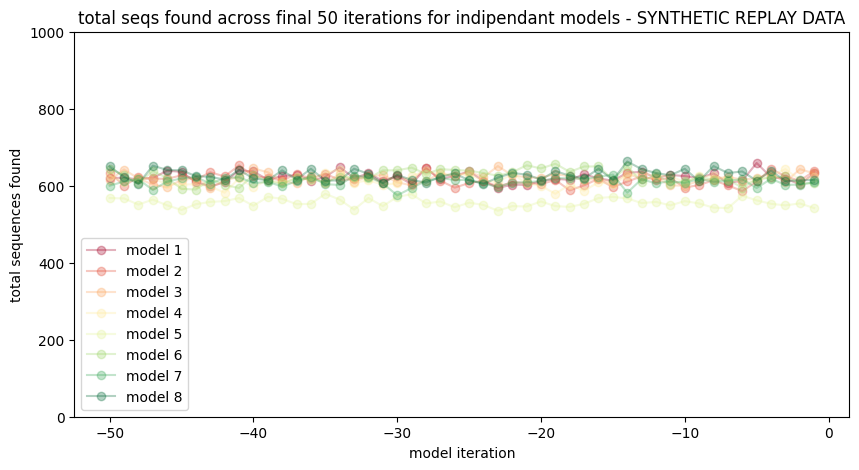

In [ ]:
AA_total_seqs  = np.load(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_total_seqs_syth_data.npy", allow_pickle = True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(AA_total_seqs)))
for i, totals in enumerate(AA_total_seqs):
    if len(totals) > 50:
        totals = totals[1::]
    label = 'model ' + str(i+1)
    ax.plot(range(-50, 0), totals, '-o', c=colors[i], alpha=0.3, label=label)
ax.set_ylim(0, 1000)
ax.set_xlabel('model iteration')
ax.set_ylabel('total sequences found')
ax.set_title('total seqs found across final 50 iterations for indipendant models - SYNTHETIC REPLAY DATA')
ax.legend()

(400.0, 900.0)

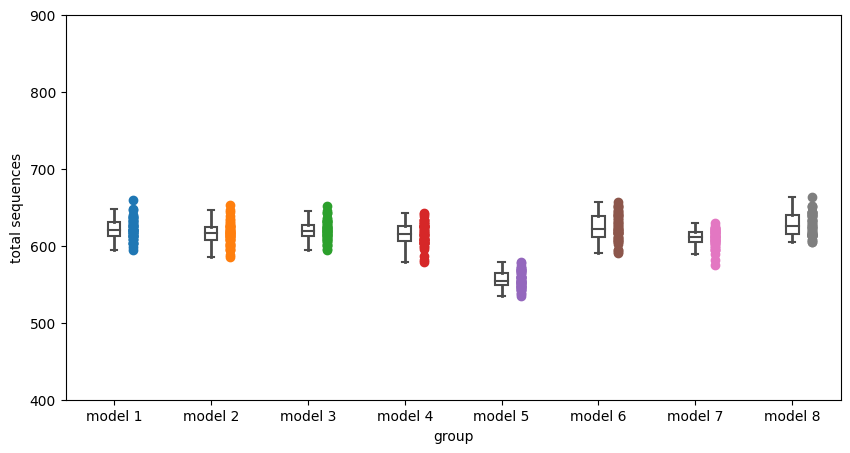

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
flattened_totals = [item for sublist in AA_total_seqs for item in sublist]
group_labels = [f'model {i+1}' for i in range(len(AA_total_seqs)) for _ in range(len(AA_total_seqs[i]))]
totals_df = pd.DataFrame({'group': group_labels, 'total sequences': flattened_totals})

for i,item in enumerate(AA_total_seqs):
    ax.plot([i+0.2]*len(item),item,'o')

ax = sns.boxplot(y='total sequences', x='group', data=totals_df, color='blue', width=.13, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')
ax.set_ylim(400, 900)

(0.0, 1000.0)

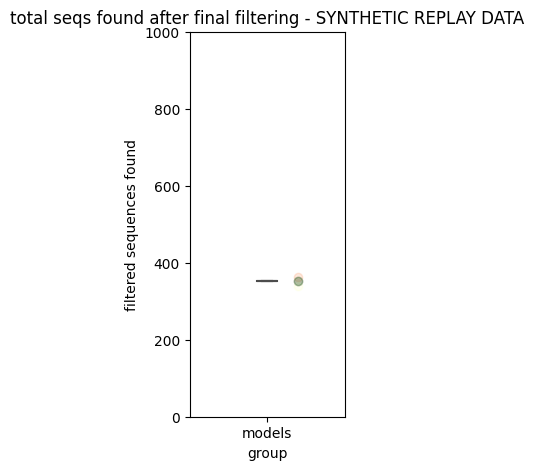

In [ ]:
AA_filtered_total_seqs = np.load(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\MCMC_plots\AA_filtered_total__synthetic_seqs.npy")

colors = plt.cm.RdYlGn(np.linspace(0, 1, len(AA_filtered_total_seqs)))

fig, ax = plt.subplots(1, 1, figsize=(2, 5))

for i,item in enumerate(AA_filtered_total_seqs):
    ax.plot(0.2, item,'o', alpha = 0.2,c=colors[i])


plt_df = pd.DataFrame({'group': ['models'] * len(AA_filtered_total_seqs), 'filtered sequences found': AA_filtered_total_seqs})
ax = sns.boxplot(y='filtered sequences found', x='group', data=plt_df, color='blue', width=.13, zorder=10,
                    showcaps=True, boxprops={'facecolor': 'none', "zorder": 10},
                    showfliers=False, whiskerprops={'linewidth': 2, "zorder": 10},
                    saturation=1, orient='v')

ax.set_title('total seqs found after final filtering - SYNTHETIC REPLAY DATA')

ax.set_ylim(0, 1000)

In [ ]:
neuron_order

NameError: name 'neuron_order' is not defined

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_38648\1787967234.py:1: SyntaxWarning: invalid escape sequence '\d'
  spikes_path = save_path + '\data_across_iterations\\'


In [40]:
os.mkdir('Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\MCMC_plots\\output\\\\178_1_7_run_1710024_1203\\_final_analysis_output\\\\data_across_iterations\\250\\')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\MCMC_plots\\output\\\\178_1_7_run_1710024_1203\\_final_analysis_output\\\\data_across_iterations\\250\\'

In [35]:
list(assignment_history_df)[300]

IndexError: list index out of range

In [31]:
assignment_history_df[1]

KeyError: 1

In [19]:
spikes_path

'D:\\MCMC\\\\'

In [17]:
os.path.join(save_path, f'chunk{0+1}_{behav_time_interval_start[0][0]}to{behav_time_interval_start[0][1]}\\')

'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\MCMC_plots\\output\\\\178_1_7_run_1710024_1203\\_final_analysis_output\\chunk1_5400to6000\\'

In [14]:
spikes_path

'D:\\MCMC\\\\'

'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\MCMC_plots\\output\\\\178_1_7_run_1710024_1203\\_final_analysis_output\\'

In [ ]:
save_path

'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\MCMC_plots\\output\\\\178_1_7_run_1710024_1203\\_final_analysis_output\\'

0         3.0
1         6.0
2         3.0
3         3.0
4         3.0
         ... 
176094   -1.0
176095   -1.0
176096   -1.0
176097   -1.0
176098   -1.0
Name: 300, Length: 176099, dtype: float64

# plot showing loss over time has stablised. 

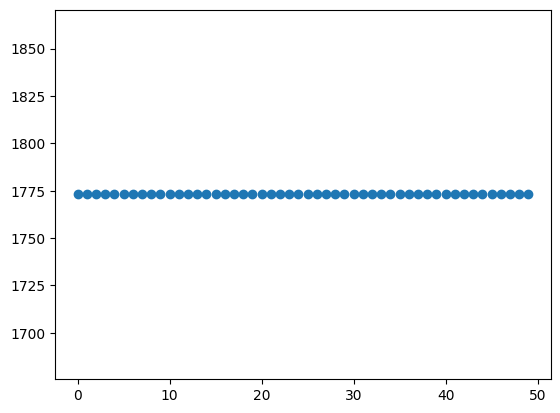

In [ ]:
    # ---filter_across_itterations---------------------------------------------------------------------------------------------------------------------------------------------------------------    
        # Initialize an empty df to store the result
        seq_types_df = pd.DataFrame()
        # Iterate through the range
        # for iteration_ in tqdm(range(400, 500)):
        for iteration_ in tqdm(range(250, 300)):
            # Extract the relevant column from the assignment history dataframe
            assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]
            # Get the index of the -1 split markers in the latent event history dataframe
            end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
            # Extract the relevant portion of the latent event history dataframe
            latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]
            # Create a dictionary from the dataframe for faster lookups
            df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()
            # Match the sequence ID to the sequence type
            seq_type = find_corresponding(assignment_history_df_split)
            # Append the result to the df
            seq_types_df[str(iteration_+1)] = seq_type
        proportion = []
        seq_type = []
        for index in tqdm(range(len(seq_types_df))):
            row = seq_types_df.loc[index]
            seq_type += [statistics.mode(row)] 
            proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]
        # add seq type to dataframe
        unmasked_spikes_df['sequence_type'] = seq_type
        # add seq type to dataframe
        unmasked_spikes_df['seq_confidence'] = proportion
        
        # ## filter for background confidence :-------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        thresh = max(proportion) *.75 ### 
        plt.plot(np.sort(proportion)[::-1])
        plt.axhline(y = thresh, color = 'r', linestyle = '-')
        unmasked_spikes_df['sequence_type_adjusted'] = seq_type
        unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1
        SaveFig('filtering_curve.png',save_path)
        
        ## load in colors and order from awake data -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
        for file_ in os.listdir(awake_PP_path):
            if mouse_session_recording in file_:
                awake_file = file_
        ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')
        neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')
        colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')
        spikes_df = unmasked_spikes_df
        colors += ['pink','lightblue', 'k'] 
        
        ############### plot simple rasters ------------------------------
        interval_end_points,neuron_order = plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, 'all_data_raster.png')
        
        
        # Constants
        min_spikes_filter = 5
        min_neurons_involved_filter = 3
        bin_size = 0.02

        # Main processing loop
        chunk_paths = []
        for index_, interval_start in enumerate([0] + list(interval_end_points)[:-1]):
            chunk_path = os.path.join(save_path, f'chunk{index_+1}_{behav_time_interval_start[index_][0]}to{behav_time_interval_start[index_][1]}\\')
            chunk_paths.append(chunk_path)
            create_directory(chunk_path)

            np.save(os.path.join(chunk_path, 'chunk_time_interval.npy'), np.array(behav_time_interval_start[index_]))

            timeframe = [interval_start, interval_end_points[index_] - 1]
            total_time = np.diff(timeframe)[0] + 1
            mask = (spikes_df.timestamp > timeframe[0]) & (spikes_df.timestamp < timeframe[-1])

            fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(35, 15))

            background_remove_mask = (spikes_df[mask].sequence_type_adjusted > -1) & (spikes_df[mask].sequence_type_adjusted < 7)
            c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
            ax1.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask], marker='o', s=40, linewidth=0, color=c_, alpha=1)

            chunk_mask = (spikes_df.timestamp > interval_start) & (spikes_df.timestamp < interval_end_points[index_])
            chunk_df = spikes_df[chunk_mask].copy().reset_index(drop=True)
            chunk_df.to_csv(os.path.join(chunk_path, 'unfiltered_spikes_data.csv'), index=False)

            seqs = np.unique(chunk_df.sequence_type_adjusted)
            seq_spikes = [chunk_df.timestamp[chunk_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]
            seq_neurons = [chunk_df.neuron[chunk_df.sequence_type_adjusted == seq_type_].values for seq_type_ in seqs]

            binned_seq_r_events = [np.histogram(spikes_, bins=np.arange(interval_start, interval_end_points[index_], bin_size))[0] for spikes_ in seq_spikes]

            strt_ = int(timeframe[0] / bin_size)
            end_ = int(timeframe[1] / bin_size)

            r_start_, r_end_, r_seq_type = [], [], []
            for _index_, sequence_type in enumerate(seqs):
                sequence_type = int(sequence_type)
                if 0 < sequence_type <= 6:
                    smoothed_binned_spikes = convolve_movmean(binned_seq_r_events[_index_], 2)
                    time_bins = np.arange(timeframe[0], timeframe[0] + np.diff(timeframe) + 1, bin_size)
                    ax2.plot(time_bins[:-1], smoothed_binned_spikes, c=colors[sequence_type])
                    ax2.sharex(ax1)

                    replay_chunks, indices = split_list(list(smoothed_binned_spikes))
                    for index, chunk in enumerate(replay_chunks):
                        r_seq_type.append(sequence_type)
                        r_start_.append(time_bins[indices[index][0]])
                        r_end_.append(time_bins[indices[index][-1]])

            filter_and_save_replay_clusters(chunk_df, chunk_path, r_seq_type, r_start_, r_end_, colors, min_spikes_filter, min_neurons_involved_filter)

            ax1.set_xlim(timeframe[0] + 140, timeframe[0] + 150)
            ax2.set_xlim(timeframe[0] + 140, timeframe[0] + 150)

            save_figure(fig, f'zoomed_data_filtering_chunk_{index_+1}.png', chunk_path)
            plt.close(fig)

